In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score 

In [29]:
def getData():
    cwd = os.getcwd()  #getting the path of this current program
    filename = cwd + '/default of credit card clients.xls'  #path + file
    
    np.random.seed(0)
    #Read file into pandas dataframe 
    nanDict= {}
    df = pd.read_excel('default of credit card clients.xls', header=1, skiprows=0, index_col=0, na_values=nanDict)
    df.rename(index=str, columns={'default payment next month': 'defaultPaymentNextMonth'}, inplace=True)

    #Drop the rows including data where parameters are out of range
    df=df.drop(df[df.SEX<1].index)
    df=df.drop(df[df.SEX<2].index)
    df=df.drop(df[(df.EDUCATION <1)].index)
    df=df.drop(df[(df.EDUCATION >4)].index)
    df=df.drop(df[df.MARRIAGE<1].index)
    df=df.drop(df[df.MARRIAGE>3].index)

    #Drop the rows for the customers that do not have any bills throughout the period as we do not want the model to train on this data
    df = df.drop(df[(df.BILL_AMT1 == 0) &
                (df.BILL_AMT2 == 0) &
                (df.BILL_AMT3 == 0) &
                (df.BILL_AMT4 == 0) &
                (df.BILL_AMT5 == 0) &
                (df.BILL_AMT6 == 0) &
                (df.PAY_AMT1 == 0) &
                (df.PAY_AMT2 == 0) &
                (df.PAY_AMT3 == 0) &
                (df.PAY_AMT4 == 0) &
                (df.PAY_AMT5 == 0) &
                (df.PAY_AMT6 == 0)].index)

    #Features and targets
    #.values returns a numpy representation of the DataFrame
    X= df.loc[:, df.columns != 'defaultPaymentNextMonth'].values 
    y= df.loc[:, df.columns == 'defaultPaymentNextMonth'].values
    
    # Categorical variables to one-hot's
    onehotencoder = OneHotEncoder(categories="auto")

    #OneHot encoder for column (2,3,5,6,7,8,9,10) [education,marriage, pay_april, pay_may, pay_jun, pay_jul, pay_aug, pay_sep]
    #Designmatrix, hotencoder on the categorical columns
    X = ColumnTransformer([('onehotencoder', onehotencoder, [2,3,5,6,7,8,9,10]),],remainder="passthrough").fit_transform(X)
    y = np.ravel(y)
    #print(y.shape)
    
    return X, np.ravel(y)

## Exploring the balance of the output classes

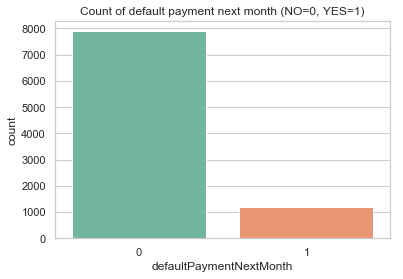

percentage of no default payment (NO=0) is 86.9632239594803
percentage of default payment (YES=1) is 13.03677604051971


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
#plot
sns.set(style="white")
sns.set(style="whitegrid")
sns.countplot(x='defaultPaymentNextMonth',data=df, palette='Set2')
plt.title('Count of default payment next month (NO=0, YES=1)')
plt.savefig('counter_plot_y.png', dpi=300)
plt.show()

#percentage calculation 
count_no_default = len(df[df['defaultPaymentNextMonth']==0])
count_default = len(df[df['defaultPaymentNextMonth']==1])
pct_of_no_default = count_no_default/(count_no_default+count_default)
print("percentage of no default payment (NO=0) is", pct_of_no_default*100)
pct_of_default = count_default/(count_no_default+count_default)
print("percentage of default payment (YES=1) is", pct_of_default*100)

We see from the above presentation that out classes are imbalanced, as our ratio of no default vs default payment is 79:21. We may stumble on some complications regaridng this imbalance as it is hard to train an a model on an imbalanced data set. Therefore, we should consider finding a way of balancing these out. Can do so by multplying the 'YES=1' gradient by some default (79/21).


Or, use some other way of evaluating the accuracy of the model.

## Fixing the imbalance in the data, scale and split into train and test data

In [82]:
X,y = getData()

#Fix the imbalance in the data 
ones_ = np.argwhere(y==1).flatten()
zeros_ = np.argwhere(y==0).flatten()


indexes = np.random.choice(zeros_,size=ones_.shape[0])
indexes = np.concatenate((indexes,ones_),axis=0)
y = y[indexes]
X = X[indexes]
indexes = np.arange(y.shape[0])
np.random.shuffle(indexes)
y = y[indexes]
X = X[indexes]

#print(np.mean(y == 1))

#Train-Test Split
trainingShare = 0.8 
seed = 1
X_train, X_test, y_train, y_test=train_test_split(X, y, train_size=trainingShare,
                                              test_size = 1-trainingShare,
                                              random_state=seed)

# Input Scaling
sc     = StandardScaler()
X_train = sc.fit_transform(X_train.todense())
X_test  = sc.transform(X_test.todense())

(17361, 79)


In [51]:
#print(np.sum(y_train)/len(y_train)) test that the length. ..

0.49868582442614334


# Logistic Regression 


0.5848957420711407
[[1697 1164]
 [1205 1641]]


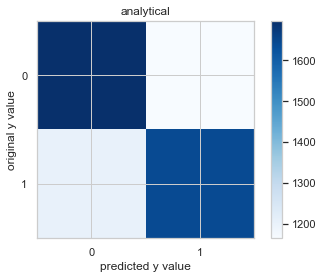

([4060.6415787328597,
  4044.085822219377,
  4026.7519791456543,
  4010.5789531687337,
  3999.1093737751607,
  3992.7436722091825,
  3989.489619004604,
  3988.680998069577,
  3988.8587156180024,
  3989.4594785431264,
  3990.146050600295,
  3990.665090187684,
  3990.9965831214568,
  3991.2043414233594,
  3991.336686266475,
  3991.4223840483805,
  3991.47852213346,
  3991.5155773751585,
  3991.5401576200397,
  3991.5565151811675,
  3991.5674236816267,
  3991.574708418218,
  3991.5795776603554,
  3991.5828343305225,
  3991.585013357442,
  3991.5864717321174,
  3991.5874479668455,
  3991.588101536606,
  3991.588539124001,
  3991.5888321196553,
  3991.5890283080444,
  3991.5891596779716,
  3991.5892476461663,
  3991.589306552246,
  3991.589345997769,
  3991.5893724119683,
  3991.5893900999627,
  3991.5894019445705,
  3991.5894098762183,
  3991.589415187588,
  3991.589418744311,
  3991.5894211260465,
  3991.589422720961,
  3991.5894237889856,
  3991.589424504182,
  3991.589424983108,
  3991.

In [98]:
from sklearn.linear_model import LogisticRegression

import numpy as np
import matplotlib.pyplot as plt
from random import random, seed

from sklearn.metrics import confusion_matrix   #to evaluate the accuracy of a classification.


class LogisticRegression_class:

    def __init__(self, learning_rate, batch_size, n_epochs, lambda_=0, tol=1e-5):
        self.learning_rate = learning_rate
        #self.n_batches = n_batches
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.lambda_ = lambda_
        self.tol = tol



    def sigmoid_function(self,x):
        return(1/(1+np.exp(-x)))

    def gradient_descent(self, X, y):   #optimizing parameters beta
        #y = y[:, np.newaxis] 
        param = np.shape(X)[1] #number of parameters
        n = np.shape(X)[0] #number of rows
        n_batches = n // self.batch_size #integer division
        beta = np.random.uniform(0.0,1.0, param)#np.random.randn(param)  #generate random initial values for beta
        #print("***",beta)


        error = []

        #n_0_list = []
        #n_1 = np.count_nonzero(y)   #total number of y=1. double check that those are really 1.
        #const = (n - n_1)/n_1
        #print("*",X.shape, y.shape)
        
        index = np.arange(n)
        np.random.shuffle(index)
        batch_split = np.array_split(index,n_batches)
        
        k = 0
        #total numer of iterations:
        for i in range(self.n_epochs):
            y_pred = self.sigmoid_function(X @ beta)
            
            #print(y_pred.shape)
            C = self.cost_function(y, y_pred)
            #abs_C  = np.abs(C_data - C)
            error.append(C)
            #print("**", beta[0])
            

            for j in batch_split:
                #gradient  = np.sum(X.T * self.sigmoid_function(X @ beta) - y[:,np.newaxis]*X) #X.T @ (self.sigmoid_function(X @ beta) * const * y)  
                gradient = np.sum ( X[j].T* (self.sigmoid_function(X[j]@beta)- y[j]))
                gradient = gradient/self.batch_size
                #print(gradient.shape)
                #learning_rate = self.learning_schedule(i*n_batches+j)     #adaptive learning rate. Sjekke om det enkelste funker forst.
                beta -= self.learning_rate * gradient
                k += 1
        
       
        self.beta = beta
        y_pred = self.sigmoid_function(X @ self.beta)
        tol = 0.5
        y_pred[y_pred >= tol] = 1
        y_pred[y_pred < tol] = 0
        #print(error)
        I = self.accuracy_function(y, y_pred)
        print(I)
        self.accuracy_matrix(y, y_pred, 'analytical')
        #print(y_pred)

        return error, self.n_epochs

    def learning_schedule(self,t):  
        t0 = 5; t1 = 50
        return t0/(t+t1)

    def fit_function(self, X_train, X_test, y_train, y_test):
        self.gradient_descent(X_train, y_train)
        y_pred = X_test @ self.beta


    def predict_sklearn(self, X_train, X_test, y_train, y_test):
        LR = LogisticRegression()
        LR.fit(X_train,y_train)
        y_pred = LR.predict(X_test)
        v = np.count_nonzero(y_pred)
        I = self.accuracy_function(y_test, y_pred)
        C = self.cost_function(y_test, y_pred)
        #print(I)
        CM = self.accuracy_matrix(y_test, y_pred, 'sklearn')

    def cost_function(self, y_data, y_pred):  #oppdatere parametrene.
        cost = -np.sum( (y_data.T * y_pred ) - np.log(1+np.exp(y_pred)))
        #print("**",cost)
        return cost
        #return -np.sum(y_data.T* np.log(y_pred) + (1-y_data.T)*np.log(1-y_pred))

    def accuracy_function(self,y_data, y_pred):  #hvor bra modellen gjor det.
        if np.shape(y_data)[0] == np.shape(y_pred)[0]:
            I = np.mean(y_data==y_pred)     ## =1 if y==y, 0 else.... np.mean #dobbelsjekk at det funker
        else:
            raise ValuError
        return I

    def accuracy_matrix(self, y_data, y_pred, title):
        fig, ax = plt.subplots()
        cm = confusion_matrix(y_data, y_pred)
        print(cm)
        cmap = plt.cm.Blues
        im = ax.imshow(cm, interpolation = 'nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks = np.arange(cm.shape[1]),
               yticks = np.arange(cm.shape[0]),
               title=title,
               xlabel='predicted y value',
               ylabel='original y value')
        plt.show()

        return cm




LogReg = LogisticRegression_class(learning_rate=0.001,batch_size=128, n_epochs=100, lambda_=0, tol=1e-5)
LogReg.gradient_descent(X_train, y_train)
#LogReg.predict_sklearn(X_train, X_test, y_train, y_test)
#Error, epochs = LogReg.gradient_descent(X_train, y_train)
#epochs = np.linspace(0,epochs, epochs)
#plt.plot(epochs, Error)
#plt.show()
#print(XTrain.shape, yTrain.shape)

## Neural Network
Testing full code for Neural Network, based on lecture notes 'Data Analysis and Machine Learning: Neural networks, from the simple perceptron to deep learning'

In [88]:
class NeuralNetwork:
    def __init__(self, X, y, n_hidden_neurons=50 , n_categories=10 , epochs=100 , batch_size=100 , eta=0.1 , lmbd=0.0):
        
        self.X = X
        self.y = y
        #self.X_full = self.X
        #self.y_full = self.y
        
        self.n_inputs         = X.shape[0]  #X-rows
        self.n_features       = X.shape[1]  #X-columns 
        self.n_hidden_neurons = n_hidden_neurons
        self.n_categories     = n_categories
        
        self.epochs           = epochs
        self.batch_size       = batch_size
        self.iterations       = self.n_inputs // self.batch_size #Floor division
        self.eta              = eta
        self.lmbd             = lmbd
        
        self.create_biases_and_weights() #gives the initial bias and weigths. 
        self.feed_forward()
        #print(self.hidden_weights)
        #print("***")
        self.backpropagation()
        #print(self.hidden_weights)        
            
    def sigmoid(self,x):
        return(1/(1 + np.exp(-x)))
        
    def create_biases_and_weights(self):
        self.hidden_weights = np.random.randn(self.n_features, self.n_hidden_neurons)
        self.hidden_bias    = np.zeros(self.n_hidden_neurons) + 0.01
        self.output_weights = np.random.randn(self.n_hidden_neurons, self.n_categories)
        self.output_bias    = np.zeros(self.n_categories) + 0.01
    
    def feed_forward(self):
        #feed_forward training
        self.z_h = np.matmul(self.X, self.hidden_weights) + self.hidden_bias
        self.a_h = self.sigmoid(self.z_h)
        
        self.z_o = np.matmul(self.a_h, self.output_weights) + self.output_bias
        
        exp_term = np.exp(self.z_o)
        self.probabilities = exp_term /np.sum(exp_term, axis=1, keepdims=True)
        
    
    def feed_forward_output(self, X):
        #feed_forward for output
        z_h = np.matmul(X, self.hidden_weights) + self.hidden_bias
        a_h = self.sigmoid(z_h)
        
        z_o = np.matmul(a_h, self.output_weights) + self.output_bias

        exp_term = np.exp(z_o)
        probabilities = exp_term/ np.sum(exp_term, axis=1, keepdims=True)
        return probabilities
    
    def backpropagation(self):
   
        error_output = self.probabilities - self.y  #Error in output layer delta^L
        error_hidden = np.matmul(error_output, self.output_weights.T) *self.a_h * (1-self.a_h) #Error for the jth neuron in lth layer delta^l
        
        self.output_weights_gradient = np.matmul(self.a_h.T, error_output)
        self.output_bias_gradient    = np.sum(error_output, axis=0)
        
        self.hidden_weights_gradient = np.matmul(self.X.T, error_hidden)
        self.hidden_bias_gradient    = np.sum(error_hidden, axis=0)
        
        
        if self.lmbd > 0.0:
            self.output_weights_gradient += self.lmbd * self.output_weights
            self.hidden_weights_gradient += self.lmbd * self.hidden_weights
            
        self.output_weights -= self.eta * self.output_weights_gradient
        self.output_bias    -= self.eta * self.output_bias_gradient
        self.hidden_weights -= self.eta * self.hidden_weights_gradient
        self.hidden_bias    -= self.eta * self.hidden_bias_gradient 
        
       
    
    
    def predict(self, X):
        probabilities = self.feed_forward_output(X)
        return np.argmax(probabilities, axis = 1)
    
    def predict_probabilities(self, X):
        probabilities = self.feed_forward_output(X)
        return probabilities
    
    
    
    #def train(self):
     #   data_ind = np.arange(self.n_inputs)
      #  print("hellu")
       # for i in range(self.epochs):
        #    for j in range(self.iterations):
                #pick datapoints with replacements
         #       chosen_datapoints = np.random.choice(data_ind, size=self.batch_size, replace=False)
                
                #minibatch training data
          #      self.X_full = self.X[chosen_datapoints]
           #     self.y_full = self.y[chosen_datapoints]
                
            #    self.feed_forward()
             #   self.backpropagation()
        
        
        
    
        
        
        
          
  
        
                

In [101]:
NN = NeuralNetwork( X, y, n_hidden_neurons=50, n_categories=10 , epochs=100 , batch_size=100 , eta=0.1 , lmbd=0.0)

NN.predict(X)


ValueError: Shape of passed values is (10, 17855), indices imply (1, 17855)